## Exploration

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import basic libraries
import matplotlib.pyplot as plt
import numpy as np
import os,shutil

# Fastai reloads
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#Impost fastai
from fastai.vision import *
from fastai.metrics import error_rate,accuracy
from fastai.callbacks import *
from fastai.imports import *
from fastai.callbacks.mem import PeakMemMetric

from pathlib import Path

from torchvision.models import *
from torch.nn import CrossEntropyLoss
import cv2
#import pretrainedmodels

from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
import seaborn as sns

In [3]:
PATH=Path('data/')

In [118]:
os.listdir(PATH)

['test_ApKoW4T.csv',
 'images',
 'models',
 'sample_submission_ns2btKE.csv',
 'test_resized',
 'train.csv',
 'train_resized',
 '.ipynb_checkpoints',
 'test',
 'rn50-stage3-history.csv',
 'rn50-stage1-history.csv',
 'rn50-stage4-history.csv',
 'rn50-stage2-history.csv']

In [78]:
df_train=pd.read_csv(PATH/'train.csv')

In [79]:
df_train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [27]:
df_train.dtypes

image       object
category     int64
dtype: object

In [33]:
label_mapper = {1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tankers'}
df_train['category'] = df_train['category'].map(label_mapper)

In [80]:
df_test=pd.read_csv(PATH/'test_ApKoW4T.csv')

In [81]:
df_test.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [10]:
len(os.listdir(PATH/'images'))

6252

In [11]:
len(df_train),len(df_test),len(df_train)+len(df_test)

(6252, 2680, 8932)

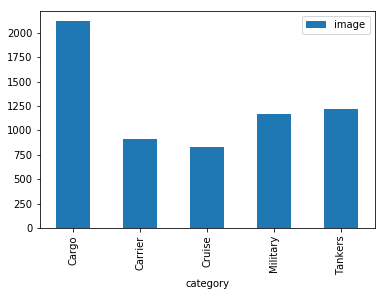

In [34]:
df_train.groupby('category').count().plot(kind='bar')

## Move the files to test folder

In [28]:
os.makedirs(PATH/'test',exist_ok=True)

In [61]:
test_img=[]
for i in range(len(df_test)):
    test_img.append(df_test.image.loc[i])

In [60]:
path = f'{PATH}/images/'
moveto = f'{PATH}/test/'
#files = test_pos
#files.sort()
for f in test_img:
    #print(str(f))
    src = path+f
    dst = moveto+f
   # print(f)
    shutil.move(src,dst)

In [13]:
len(os.listdir(path)),len(os.listdir(moveto))

NameError: name 'path' is not defined

In [12]:
PATH/'images'

PosixPath('data/images')

In [13]:
PATH

PosixPath('data')

## For train images

In [15]:
size_d={k: PIL.Image.open(PATH/'images'/k).size for k in os.listdir(PATH/'images')}

In [16]:
col_sz,row_sz=list(zip(*size_d.values()))
row_sz=np.array(row_sz)
col_sz=np.array(col_sz)

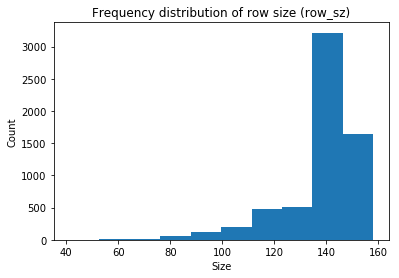

In [17]:
plt.hist(row_sz)
plt.title('Frequency distribution of row size (row_sz)')
plt.xlabel('Size');plt.ylabel('Count')
plt.show()

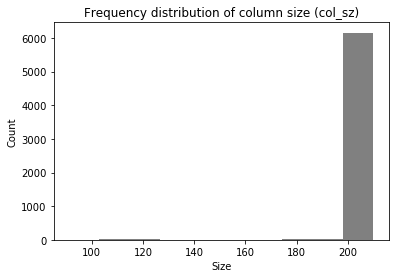

In [18]:
plt.hist(col_sz,color='gray')
plt.title('Frequency distribution of column size (col_sz)')
plt.xlabel('Size');plt.ylabel('Count')
plt.show()

In [19]:
PATH

PosixPath('data')

In [4]:
# Let us resize it column =210 and row=210
def resize_img(file):
    os.makedirs(PATH/'train_resized_210',exist_ok=True)
    img=cv2.imread(str(PATH)+'/images/'+file, cv2.IMREAD_UNCHANGED)
    resized=cv2.resize(img,(210, 210), interpolation = cv2.INTER_AREA)
    cv2.imwrite(str(PATH)+'/train_resized_210/'+file,resized)

In [5]:
for img in os.listdir(PATH/'images'):
    if img.endswith('.jpg'):
        resize_img(img)
    else:
        None    

## For test images

In [23]:
size_d={k: PIL.Image.open(PATH/'test'/k).size for k in os.listdir(PATH/'test/')}

In [24]:
col_sz,row_sz=list(zip(*size_d.values()))
row_sz=np.array(row_sz)
col_sz=np.array(col_sz)

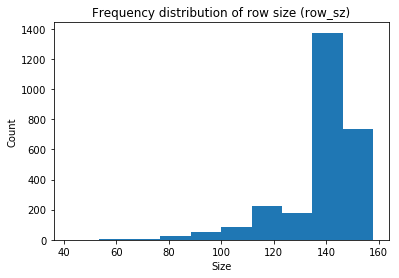

In [25]:
plt.hist(row_sz)
plt.title('Frequency distribution of row size (row_sz)')
plt.xlabel('Size');plt.ylabel('Count')
plt.show()

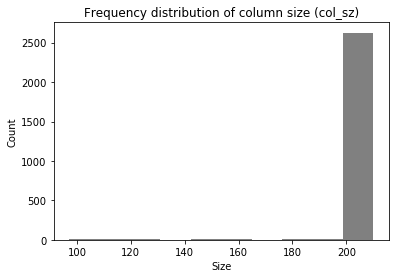

In [26]:
plt.hist(col_sz,color='gray')
plt.title('Frequency distribution of column size (col_sz)')
plt.xlabel('Size');plt.ylabel('Count')
plt.show()

In [6]:
# Test images are of similar distribution, let us resize
# Let us resize it column =210 and row=150
def resize_img(file):
    os.makedirs(PATH/'test_resized_210',exist_ok=True)
    img=cv2.imread(str(PATH)+'/test/'+file, cv2.IMREAD_UNCHANGED)
    resized=cv2.resize(img,(210, 150), interpolation = cv2.INTER_AREA)
    cv2.imwrite(str(PATH)+'/test_resized_210/'+file,resized)


In [7]:
for img in os.listdir(PATH/'test'):
    if img.endswith('.jpg'):
        resize_img(img)
    else:
        None  

## Create Data block (Try with half size)

In [4]:
tfms=get_transforms(max_rotate=20,max_zoom=1.3,p_lighting=.8,
                    xtra_tfms=[cutout(n_holes=(1,4), length=(5, 10), p=.75), jitter(magnitude=0.005, p=.25)])

In [5]:
img=open_image(PATH/'train_resized_210'/os.listdir(PATH/'train_resized_210')[1])

In [6]:
img.shape

torch.Size([3, 210, 210])

In [7]:
src_size=np.array(img.shape[1:]);src_size

array([210, 210])

In [8]:
np.random.seed(42)
src = (ImageList.from_csv(PATH, 'train.csv', folder='train_resized_210')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' ')
      .add_test_folder('test_resized_210'))

In [9]:
data = (src.transform(tfms, size=src_size//2)
        .databunch(bs=256).normalize(imagenet_stats))

In [10]:
data.classes

['1', '2', '3', '4', '5']

In [17]:
data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105)
y: EmptyLabelList
,,,,
Path: data

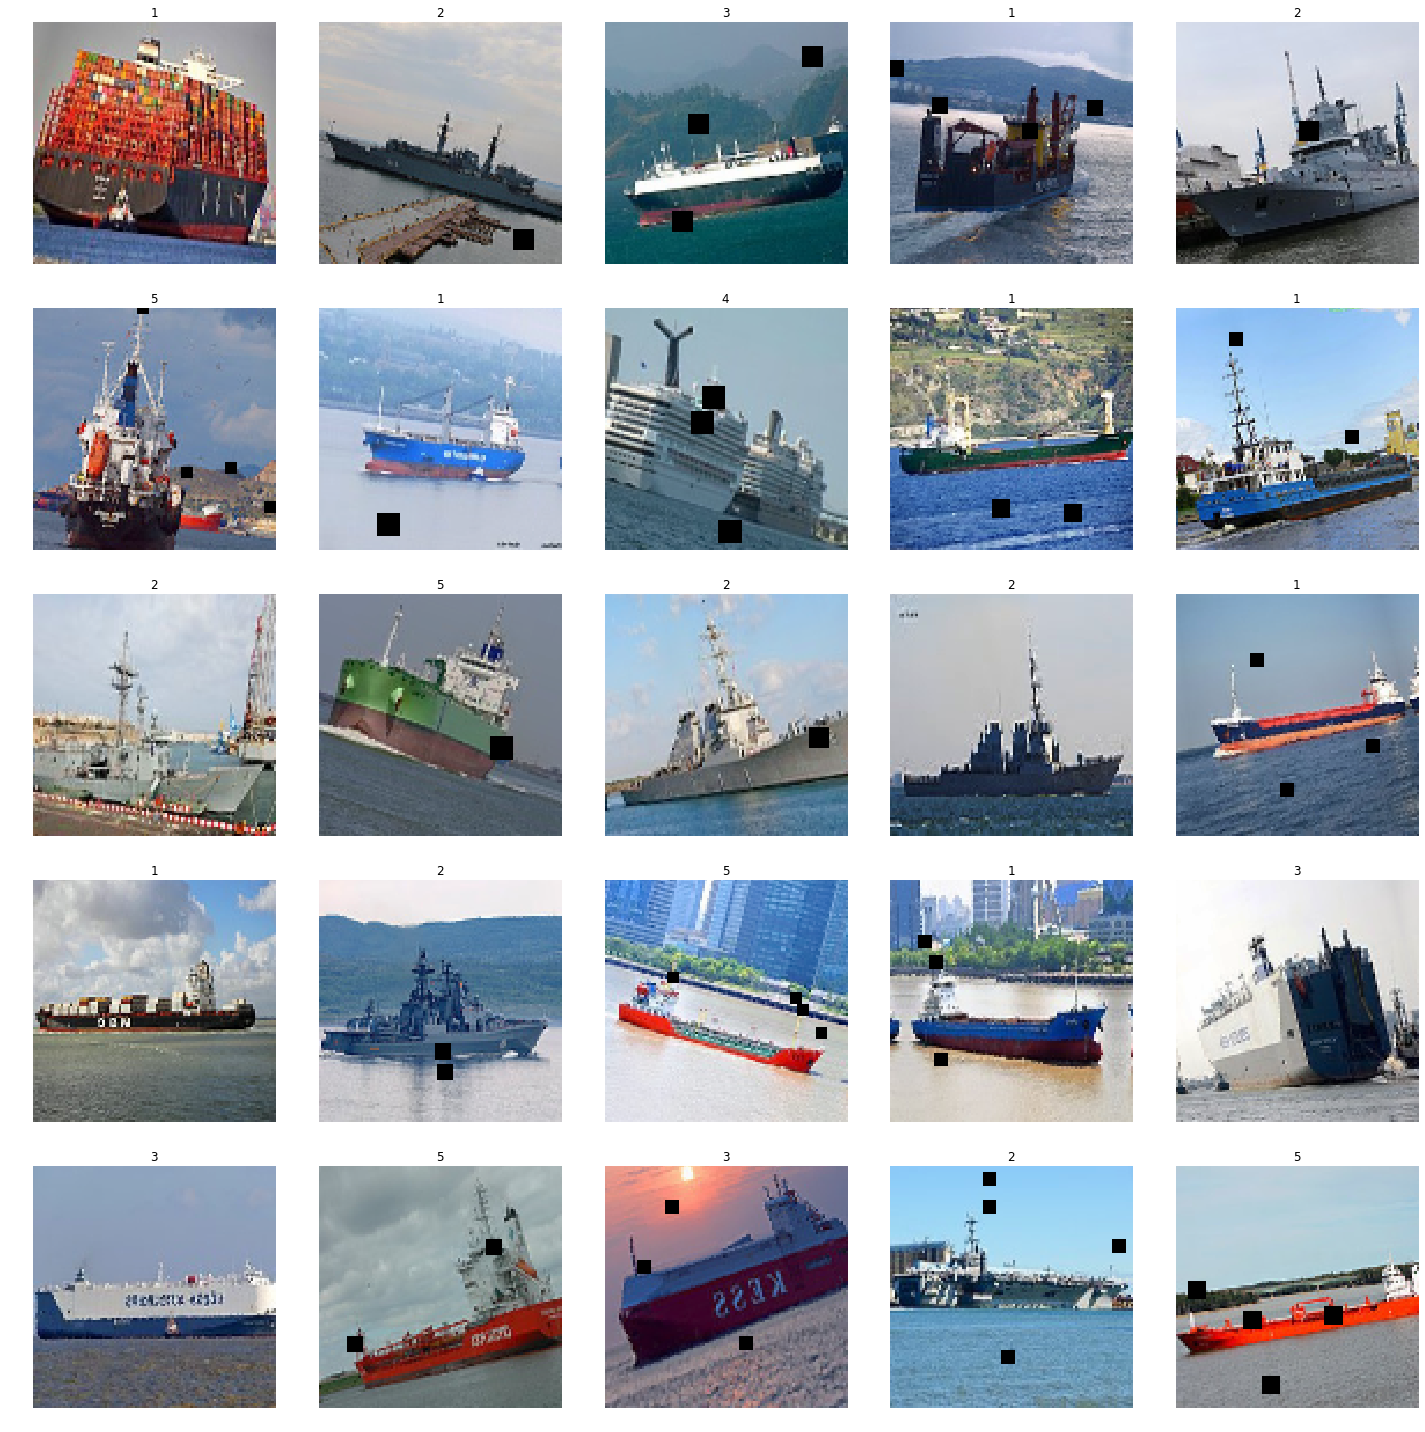

In [18]:
data.show_batch()

## Try with ResNET 50

In [10]:
metrics_custom=[fbeta,accuracy_thresh]

In [11]:
learn=cnn_learner(data,models.resnet50,metrics=metrics_custom)

In [13]:
stage1_rn50_call_back=[CSVLogger(learn=learn, filename='img210-rn50-stage1-history'), ShowGraph(learn=learn),
                       EarlyStoppingCallback(learn=learn,monitor='fbeta', min_delta=0.001, patience=5),
                          SaveModelCallback(learn,monitor='fbeta', mode='max',name='img210-rn_50_best_stage-1-aug'),
                          PeakMemMetric(learn)]

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


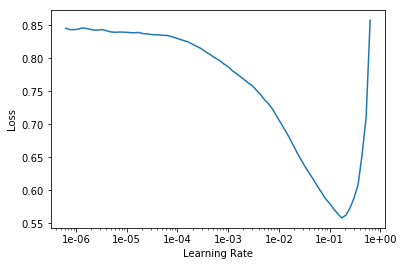

In [15]:
learn.recorder.plot()

In [16]:
lr=3e-2

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,cpu used,peak,gpu used,peak,time
0,0.614431,0.470803,0.667943,0.795200,0,0,144,11726,00:08
1,0.450057,0.242737,0.776152,0.899360,0,0,0,6502,00:07
2,0.346167,0.223863,0.833352,0.918080,0,0,0,6502,00:07
3,0.281169,0.167176,0.870629,0.932000,0,0,0,6502,00:07
4,0.235491,0.156601,0.877924,0.937760,0,0,0,6502,00:07
5,0.203252,0.164872,0.871067,0.935200,0,0,0,6502,00:06
6,0.180781,0.165191,0.887467,0.940800,0,0,0,6502,00:06
7,0.157374,0.139925,0.893714,0.945280,0,0,0,6502,00:06
8,0.139893,0.144667,0.891638,0.945760,0,0,0,6502,00:07
9,0.124433,0.121412,0.910324,0.953760,0,0,0,6502,00:07


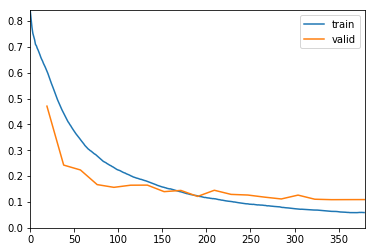

Better model found at epoch 0 with fbeta value: 0.6679428815841675.
Better model found at epoch 1 with fbeta value: 0.7761524319648743.
Better model found at epoch 2 with fbeta value: 0.8333523273468018.
Better model found at epoch 3 with fbeta value: 0.8706285953521729.
Better model found at epoch 4 with fbeta value: 0.877923846244812.
Better model found at epoch 6 with fbeta value: 0.8874667286872864.
Better model found at epoch 7 with fbeta value: 0.8937142491340637.
Better model found at epoch 9 with fbeta value: 0.9103237986564636.
Better model found at epoch 13 with fbeta value: 0.9132000207901001.
Better model found at epoch 14 with fbeta value: 0.9179428815841675.
Better model found at epoch 16 with fbeta value: 0.920457124710083.
Better model found at epoch 18 with fbeta value: 0.9207809567451477.


In [17]:
learn.fit_one_cycle(20,slice(lr),callbacks=stage1_rn50_call_back)

In [18]:
learn.load('img210-rn_50_best_stage-1-aug')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105),Image (3, 105, 105)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stri

In [19]:
learn.unfreeze()

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


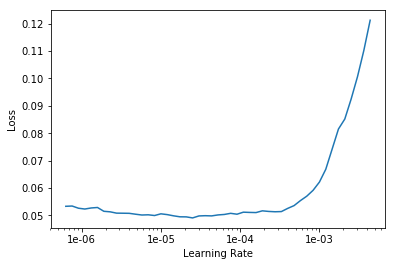

In [21]:
learn.recorder.plot()

In [22]:
lr=1e-5

In [24]:
stage2_rn50_call_back=[CSVLogger(learn=learn, filename='img210-rn50-stage2-history'), ShowGraph(learn=learn),
                       EarlyStoppingCallback(learn=learn,monitor='fbeta', min_delta=0.001, patience=5),
                          SaveModelCallback(learn,monitor='fbeta', mode='max',name='img-210-rn_50_best_stage-2-aug'),
                          PeakMemMetric(learn)]

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,cpu used,peak,gpu used,peak,time
0,0.056631,0.129458,0.907238,0.951520,0,0,3054,2816,00:07
1,0.061131,0.173159,0.885733,0.946240,0,0,50,5780,00:07
2,0.071550,0.214376,0.887105,0.945280,0,0,0,5830,00:07
3,0.082671,0.306919,0.856609,0.935680,0,0,0,5830,00:07
4,0.087999,0.130114,0.915581,0.957440,0,0,0,5830,00:07
5,0.085099,0.110825,0.922305,0.960320,0,0,0,5830,00:07
6,0.076811,0.160978,0.902667,0.957120,0,0,0,5830,00:07
7,0.071137,0.133150,0.909010,0.953600,0,0,0,5830,00:07
8,0.063933,0.097115,0.936705,0.969280,0,0,0,5830,00:07
9,0.055835,0.110919,0.926933,0.960800,0,0,0,5830,00:07


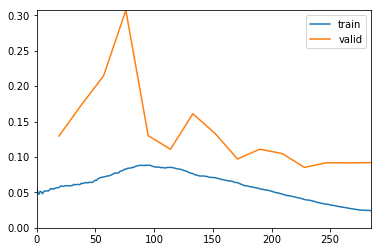

Better model found at epoch 0 with fbeta value: 0.9072380661964417.
Better model found at epoch 4 with fbeta value: 0.9155809283256531.
Better model found at epoch 5 with fbeta value: 0.9223048090934753.
Better model found at epoch 8 with fbeta value: 0.9367048144340515.
Better model found at epoch 11 with fbeta value: 0.9394667148590088.
Better model found at epoch 12 with fbeta value: 0.9412000775337219.


In [25]:
learn.fit_one_cycle(15,slice(lr,3e-2),callbacks=stage2_rn50_call_back)

## Pass full size image

In [12]:
data = (src.transform(tfms, size=src_size)
        .databunch(bs=128).normalize(imagenet_stats))

In [27]:
learn=learn.load('img-210-rn_50_best_stage-2-aug')

In [28]:
model_summary(learn)

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 105, 105]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 105, 105]       128        True      
______________________________________________________________________
ReLU                 [64, 105, 105]       0          False     
______________________________________________________________________
MaxPool2d            [64, 53, 53]         0          False     
______________________________________________________________________
Conv2d               [64, 53, 53]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 53, 53]         128        True      
______________________________________________________________________
Conv2d               [64, 53, 53]         36,864     True      
______________________________________________________________

In [29]:
learn.freeze()

In [119]:
model_summary(learn)

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 75, 105]        9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 75, 105]        128        True      
______________________________________________________________________
ReLU                 [64, 75, 105]        0          False     
______________________________________________________________________
MaxPool2d            [64, 38, 53]         0          False     
______________________________________________________________________
Conv2d               [64, 38, 53]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 38, 53]         128        True      
______________________________________________________________________
Conv2d               [64, 38, 53]         36,864     False     
______________________________________________________________

In [13]:
learn.data=data

In [31]:
learn.data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210)
y: EmptyLabelList
,,,,
Path: data

In [32]:
stage3_rn50_call_back=[CSVLogger(learn=learn, filename='img210-rn50-stage3-history'), ShowGraph(learn=learn),
                       EarlyStoppingCallback(learn=learn,monitor='fbeta', min_delta=0.001, patience=5),
                          SaveModelCallback(learn,monitor='fbeta', mode='max',name='img-210-rn_50_best_stage-3-aug'),
                          PeakMemMetric(learn)]

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


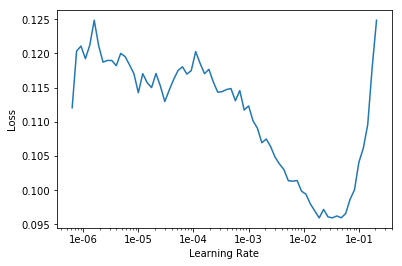

In [34]:
learn.recorder.plot()

In [35]:
lr=2e-3

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,cpu used,peak,gpu used,peak,time
0,0.110731,0.143228,0.911333,0.958880,0,0,202,12144,00:16
1,0.101087,0.119959,0.922743,0.962080,0,0,0,11564,00:15
2,0.084286,0.101340,0.927243,0.965440,0,0,0,11564,00:15
3,0.074237,0.086914,0.938443,0.966880,0,0,0,11564,00:15
4,0.063162,0.084415,0.941543,0.967200,0,0,0,11564,00:15
5,0.055005,0.081655,0.943143,0.969120,0,0,0,11564,00:15
6,0.051622,0.077671,0.946038,0.969280,0,0,0,11564,00:15
7,0.044969,0.074870,0.947905,0.973120,0,0,0,11564,00:15
8,0.042335,0.072529,0.948838,0.973600,0,0,0,11564,00:15
9,0.038798,0.072724,0.949371,0.974560,0,0,0,11564,00:15


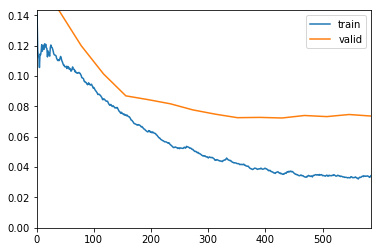

Better model found at epoch 0 with fbeta value: 0.9113333821296692.
Better model found at epoch 1 with fbeta value: 0.9227429628372192.
Better model found at epoch 2 with fbeta value: 0.9272428750991821.
Better model found at epoch 3 with fbeta value: 0.9384428858757019.
Better model found at epoch 4 with fbeta value: 0.9415427446365356.
Better model found at epoch 5 with fbeta value: 0.9431428909301758.
Better model found at epoch 6 with fbeta value: 0.9460380673408508.
Better model found at epoch 7 with fbeta value: 0.9479047060012817.
Better model found at epoch 8 with fbeta value: 0.9488381743431091.
Better model found at epoch 9 with fbeta value: 0.9493714570999146.
Better model found at epoch 10 with fbeta value: 0.95070481300354.


In [36]:
learn.fit_one_cycle(15,slice(lr),callbacks=stage3_rn50_call_back,wd=1e-3)

In [14]:
learn.load('img-210-rn_50_best_stage-3-aug')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stri

In [15]:
learn.unfreeze()

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


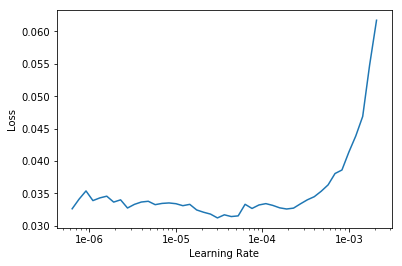

In [40]:
learn.recorder.plot()

In [16]:
lr=4e-6

In [17]:
stage4_rn50_call_back=[CSVLogger(learn=learn, filename='img210-rn50-stage4-history'), ShowGraph(learn=learn),
                       EarlyStoppingCallback(learn=learn,monitor='fbeta', min_delta=0.001, patience=5),
                          SaveModelCallback(learn,monitor='fbeta', mode='max',name='img210-rn_50_best_stage-4-aug'),
                          PeakMemMetric(learn)]

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,cpu used,peak,gpu used,peak,time
0,0.034355,0.072174,0.949905,0.974240,0,0,3124,10970,00:23
1,0.034444,0.067500,0.951638,0.975200,0,0,0,10344,00:18
2,0.030242,0.083233,0.945867,0.974080,0,0,0,10344,00:18
3,0.027217,0.093423,0.940438,0.971520,0,0,0,10344,00:18
4,0.024311,0.059291,0.961905,0.979680,0,0,0,10344,00:19
5,0.020997,0.075046,0.950171,0.974240,0,0,0,10344,00:18
6,0.017968,0.089544,0.946876,0.976160,0,0,0,10344,00:19
7,0.016140,0.083602,0.948000,0.976160,0,0,0,10344,00:19
8,0.013372,0.073149,0.951733,0.978240,0,0,0,10344,00:19
9,0.011109,0.073223,0.956533,0.980320,0,0,0,10344,00:18


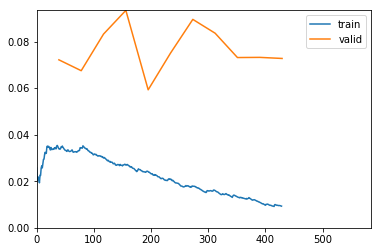

Better model found at epoch 0 with fbeta value: 0.9499047994613647.
Better model found at epoch 1 with fbeta value: 0.9516381025314331.
Better model found at epoch 4 with fbeta value: 0.961904764175415.
Epoch 10: early stopping


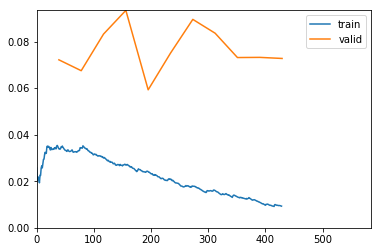

In [18]:
learn.fit_one_cycle(15,slice(lr,2e-3),callbacks=stage4_rn50_call_back,wd=1e-3)

In [19]:
learn.load('img210-rn_50_best_stage-4-aug')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stri

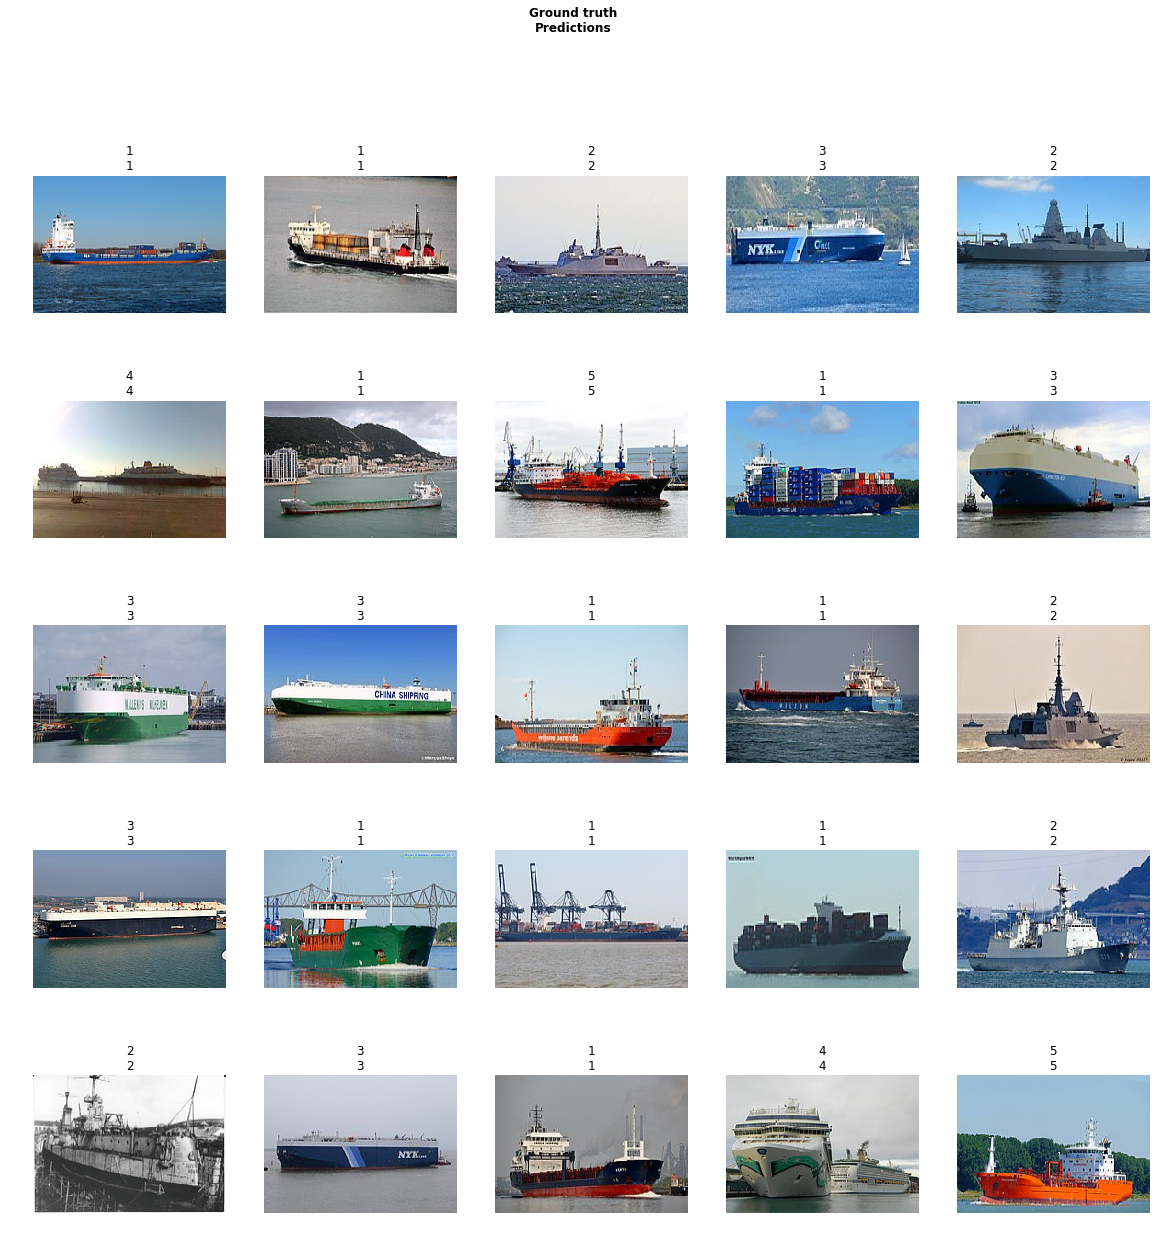

In [139]:
learn.show_results(3)

In [21]:
interp=ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Valid)

In [145]:
data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data

In [22]:
losses,idxs = interp.top_losses()

In [23]:
len(data.valid_ds)==len(losses)==len(idxs)

False

In [24]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)

In [25]:
test_pred_tta

(tensor([[9.9379e-01, 2.3280e-04, 2.5841e-03, 1.9009e-04, 2.0831e-04],
         [2.8470e-07, 5.4073e-06, 1.0000e+00, 6.9213e-06, 6.6977e-07],
         [3.2363e-01, 1.1816e-01, 2.3872e-03, 1.5659e-02, 4.0982e-01],
         ...,
         [1.2494e-02, 3.0763e-02, 9.2591e-01, 2.5665e-02, 1.2180e-02],
         [1.4449e-02, 9.6567e-01, 1.6983e-04, 3.4389e-02, 1.2169e-03],
         [7.4031e-01, 4.3979e-04, 1.7915e-03, 5.3382e-04, 2.3504e-01]]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [26]:
preds = np.argmax(test_pred_tta[0], 1)
preds

tensor([0, 2, 4,  ..., 2, 1, 0])

In [27]:
a=array(preds)

In [28]:
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]

In [29]:
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.head(10)

,image,category
0,2904735.jpg,1
1,2890616.jpg,3
2,2902677.jpg,5
3,2741468.jpg,4
4,2802610.jpg,5
5,1630950.jpg,4
6,2882184.jpg,3
7,2787793.jpg,2
8,2866032.jpg,1
9,2369442.jpg,2


In [171]:
len(submission)

2680

In [30]:
submission.to_csv(PATH/'submission_resnet50-img210.csv',index=False)